## Kaytoo | Model Evaluation & Validating Inference
### Bird Call Classification for New Zealand 
This notebook builds the inference code for Kaytoo, and evaluates its performance.  The final functions and classes for actual deployment are to be moved into seperate `.py` scripts, so I can import them consistently into the inference `.py` script for deployment.

## Basic Setup
Adjust the dictionary below for the overall notebook use case.  Note that I am processing different sound clips in parallel.  If using the GPU this results in multiple batches being sent to the GPU by different cores, so the number of cores needs to be reduced.  With 4Gb VRAM, max num_cores is 2.  This is still faster than CPU only with 6 cores.  

**Benchmarking on 39 x 15-minute .wav files on a Dell G7**

- 2-cores GPU = 55 seconds
- 6-cores CPU = 103 seconds

In [ ]:
dummy_cell = 0

In [1]:
notebook_use = {
                'project_root': '/home/olly/Desktop/Kaggle_BC25', 
                'experiment': '175',
                'bird_name_csv': 'Data/Experiments/Exp_91/Exp_91_Deploy/exp_91_bird_map.csv',
                'folder_to_process': 'Data/Original_Data/birdclef-2025/test_soundscapes',
                'model_choices': [0],
                'cpu_only': False,
                'num_cores': 1  #Can crank this up if using CPU only.
                }

## Imports

In [2]:
#General Python
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from IPython.display import Image, display
import re
import yaml

#External classes and functions
from bird_naming_utils import BirdNamer
from kaytoo_infer import  inference, ImageDataset, Models, get_images

#Math & Plotting
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Machine Learning 
#import albumentations as A
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

#Torch and PyTorch specific
#import timm
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import pytorch_lightning as pl
from torch.utils.data import  DataLoader
#from torchaudio.functional import compute_deltas

#Audio
import librosa
#import torchaudio
from scipy.signal import resample

print('Imports Complete')

Imports Complete


## Configuration Classes

In [3]:
class DefaultConfig:
    def __init__(self, bird_namer, options=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if options:
            if options['cpu_only']:
                self.device = torch.device('cpu')
            if options['num_cores']:
                self.CORES = options['num_cores']
            else:
                self.CORES = 1
        self.classes = bird_namer.bird_list

In [4]:
class AudioParameters:
    def __init__(self):
        self.SR = 32000
        self.FMIN = 20
        self.FMAX = 14000 

In [5]:
class ModelParameters:
   def __init__(self, options=None):
        '''
        _parameters_list = [
                            {'basename':'tf_efficientnet_b0.ns_jft_in1k', 
                                            'ckpt_path': model_path,
                                            'image_shape': (1,2), #The layout of 5-sec spectrograms stacked into the final image (height x width)
                                            'image_time': 10,
                                            'n_mels': 256,
                                            'n_fft': 2048,
                                            'use_deltas' : True,
                                            'hop_length': 1243,
                                            '5_sec_width': 128,
                                            'aggregation': 'mean',
                                            }, 
                            ] 
        '''

        _deploy_fldr = Path(f"{options['project_root']}/Data/Experiments/Exp_{options['experiment']}/Exp_{options['experiment']}_Deploy")
        print(str(_deploy_fldr))
        ckpt_files = list(_deploy_fldr.glob("*.ckpt"))
        cfg_files = list(_deploy_fldr.glob("*.yaml"))
        print(ckpt_files)
        print(cfg_files)
        latest_ckpt = max(ckpt_files, key=lambda f: f.stat().st_mtime)  #There should only be one  
        latest_cfg = max(cfg_files, key=lambda f: f.stat().st_mtime)  #There should only be one
        with open(latest_cfg, "r") as f:
            model_config = yaml.load(f, Loader=yaml.FullLoader)
            model_config['ckpt_path'] = latest_ckpt
        self.parameters = [model_config]

In [6]:
class FilePaths:
    AUDIO_TYPES = {'.ogg','.wav', '.flac', '.mp3'}
    def __init__(self, options=None):
        self.root_folder = Path(options['project_root'])
        self.data_folder = self.root_folder / 'Data'
        self.train_audios = self.data_folder / 'Original_Data/birdclef-2025/train_audio'
        self.experiment_results = self.data_folder / f"Experiments/Exp_{options['experiment']}/Results"
        self.val_csv = self.experiment_results / 'val_labels.csv'
        self.bird_list_path = self.root_folder / options['bird_name_csv']
        self.soundscapes_folder = self.root_folder /options['folder_to_process']
        self.soundscapes = [path for path in self.soundscapes_folder.rglob('*') if path.suffix in self.AUDIO_TYPES]
        self.predictions_csv = self.soundscapes_folder / 'predictions.csv'
        self.learning_rate_monitor = self.experiment_results / f"exp_{options['experiment']}_training_metrics.jpg"
        self.train_metric_monitor = self.experiment_results / 'learning_rate.jpg'
        self.val_preds = self.experiment_results / 'val_pred_df.pkl'
        self.val_targs = self.experiment_results / 'val_target_df.pkl'

## Helper Functions

In [7]:
class Colour:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

In [8]:
def show_batch(img_ds, model_args, num_rows, num_cols):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, _ = img_ds[index]  #returns an image of n chunks
        shape=img.shape
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, 
                                       x_axis='time', 
                                       y_axis='mel', 
                                       sr=32000, 
                                       n_fft=model_args['n_fft'] * model_args['image_shape'][0],
                                       hop_length=model_args['hop_length'],
                                       ax=ax)
        ax.set(title=f'Loading Index {index}, shape: {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")

## Initialise

In [9]:
audio = AudioParameters()
paths = FilePaths(options=notebook_use)
bird_map_df = pd.read_csv(paths.bird_list_path)
birdnames = BirdNamer(bird_map_df)

cfg = DefaultConfig(bird_namer=birdnames, 
                    options=notebook_use)
parameters = ModelParameters(options=notebook_use)
models = Models(config=cfg, 
                model_parameters=parameters, 
                audio_parameters=audio)

print('The inference folder is:', paths.soundscapes_folder)
print(f'There are {len(models.args_list)} model(s) to be ensembled')
print(f'The model(s) will predict the following {len(models.ebirds)} classes (referring to their https://ebird.org code): \n')
for i in range(0, len(models.ebirds), 10):
    print(", ".join(models.ebirds[i:i + 10]))

/home/olly/Desktop/Kaggle_BC25/Data/Experiments/Exp_175/Exp_175_Deploy
[PosixPath('/home/olly/Desktop/Kaggle_BC25/Data/Experiments/Exp_175/Exp_175_Deploy/epoch=9-step=10041.ckpt')]
[PosixPath('/home/olly/Desktop/Kaggle_BC25/Data/Experiments/Exp_175/Exp_175_Deploy/exp_175_config.yaml')]
The inference folder is: /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes
There are 1 model(s) to be ensembled
The model(s) will predict the following 206 classes (referring to their https://ebird.org code): 

1139490, 1192948, 1194042, 126247, 1346504, 134933, 135045, 1462711, 1462737, 1564122
21038, 21116, 21211, 22333, 22973, 22976, 24272, 24292, 24322, 41663
41778, 41970, 42007, 42087, 42113, 46010, 47067, 476537, 476538, 48124
50186, 517119, 523060, 528041, 52884, 548639, 555086, 555142, 566513, 64862
65336, 65344, 65349, 65373, 65419, 65448, 65547, 65962, 66016, 66531
66578, 66893, 67082, 67252, 714022, 715170, 787625, 81930, 868458, 963335
amakin1, amekes, ampkin1, 

In [10]:
print('\nThe parameters for the first model are:')
for parameter, value in models.args_list[0].items():
    print(f'{parameter}: {value}')


The parameters for the first model are:
5_sec_width: 768
aggregation: mean
basename: timm/resnest14d.gluon_in1k
buffer_audio: 1
double_audio: True
hop_length: 500
image_shape: (2, 0.5)
image_time: 12
n_fft: 2048
n_mels: 192
use_deltas: True
ckpt_path: /home/olly/Desktop/Kaggle_BC25/Data/Experiments/Exp_175/Exp_175_Deploy/epoch=9-step=10041.ckpt


## Varify the dataset on a Single Soundscape

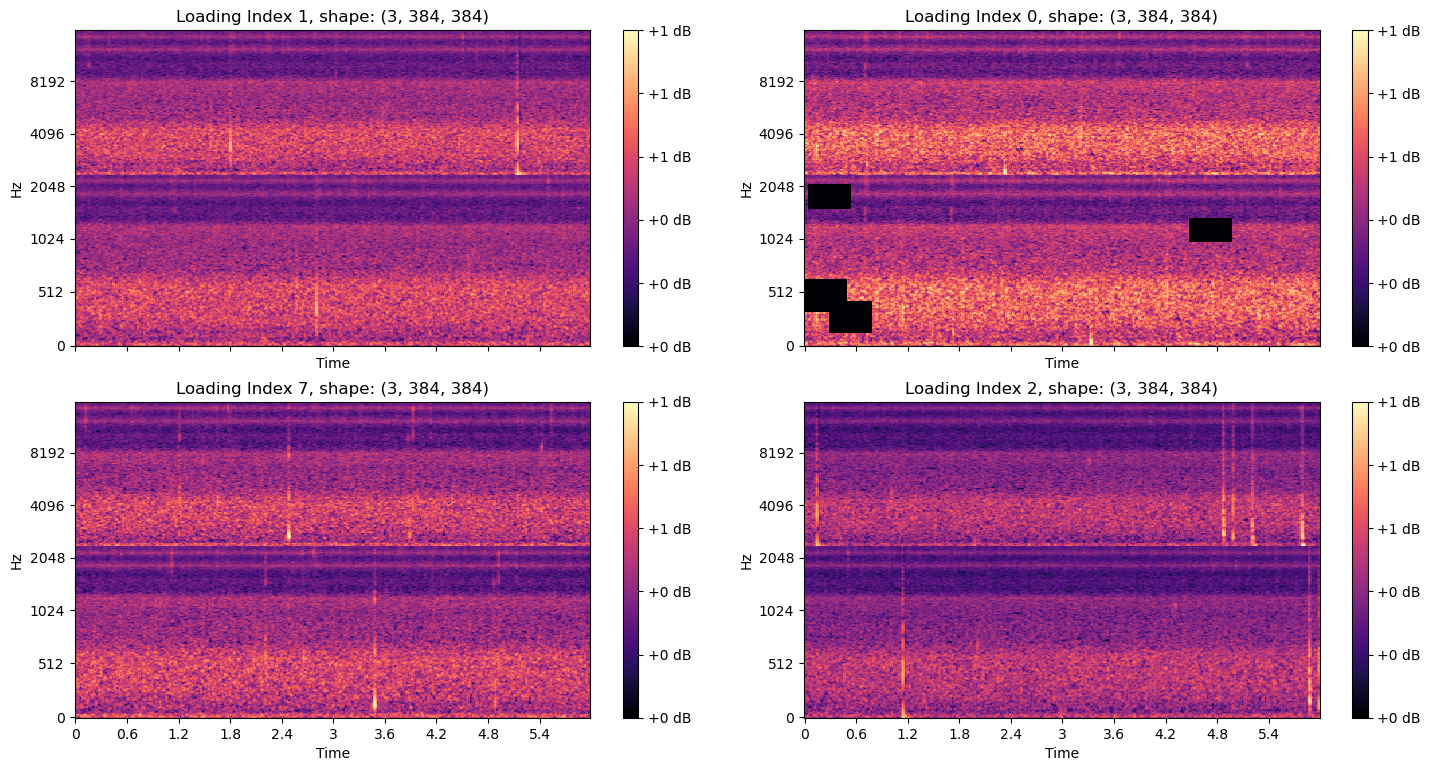

In [11]:
soundscape = random.choice(paths.soundscapes)
image_dict, num_extras = get_images(soundscape, models.args_list[0], audio_params=models.audio)
image_shape = models.args_list[0]['image_shape']
use_deltas = models.args_list[0]['use_deltas']
dataset = ImageDataset(image_dict, image_shape, use_deltas, train=True)
show_batch(dataset, models.args_list[0], 2,2)

## Analysis of Training Metrics

### Class Sizes and Distributions

First lets look at the classes and their sizes.

In [12]:
bird_map_df = bird_map_df.sort_values(by='TrainSamples').reset_index(drop=True)
bird_map_df.head(45)

eBird                       CommonName                ScientificName  \
0   rutpuf1         Russet-throated Puffbird           Hypnelus ruficollis   
1     42007                    Mountain Lion                 Puma concolor   
2   1139490             Ragoniella pulchella          Ragoniella pulchella   
3     21116  Yellow-striped Poison Dart Frog         Dendrobates truncatus   
4   1194042              Copiphora colombiae           Copiphora colombiae   
5     47067  Brown-throated Three-toed Sloth           Bradypus variegatus   
6    476537             Colombian Plump Frog        Elachistocleis pearsei   
7    476538              Panama Humming Frog     Elachistocleis panamensis   
8    523060         Eschatoceras bipunctatus      Eschatoceras bipunctatus   
9   piwtyr1                Pied Water-Tyrant                Fluvicola pica   
10  plctan1            Plain-colored Tanager              Tangara inornata   
11    24272                 Masked Tree Frog              Smilisca phaeota   
12    24322            Red Snouted Tree Frog                  Scinax ruber   
13    24292        Caracas Snouted Tree Frog              Scinax rostratus   
14    41778          Neotropical River Otter            Lontra longicaudis   
15   528041               Orophus conspersus            Orophus conspersus   
16   turvul                   Turkey Vulture                Cathartes aura   
17   548639               Copiphora gracilis            Copiphora gracilis   
18    65349               Harlequin Treefrog      Dendropsophus ebraccatus   
19    65419           Esmereldas Robber Frog             Diasporus gularis   
20  shghum1        Shining-green Hummingbird           Chrysuronia goudoti   
21  sahpar1            Saffron-headed Parrot               Pyrilia pyrilia   
22   555142        Chirique-Flusse Tree Frog                  Boana pugnax   
23    64862   Colombian Niputidea Nurse Frog           Allobates niputidea   
24    65336       Bogert's Aquatic Tree Frog         Dendropsophus bogerti   
25    65344   Boettger's Colombian Tree Frog     Dendropsophus columbianus   
26    81930                    Rivero's Toad            Rhinella humboldti   
27   868458             Typophyllum inflatum          Typophyllum inflatum   
28   714022         Panoploscelis specularis      Panoploscelis specularis   
29   787625           Santa Rita Rocket Frog    Leucostethus fraterdanieli   
30   963335                Subria sylvestris             Subria sylvestris   
31    66016                  Vaillant's Frog          Lithobates vaillanti   
32    65962          Savage's Thin-toed Frog         Leptodactylus savagei   
33    65547              Tatayo's Glass Frog     Hyalinobatrachium tatayoi   
34    41970                           Jaguar                 Panthera onca   
35  1192948            Oxyprora surinamensis         Oxyprora surinamensis   
36    21038               Common Rocket Frog        Colostethus inguinalis   
37    66531              Cachabi Robber Frog        Pristimantis achatinus   
38    66578               Bogota Robber Frog       Pristimantis bogotensis   
39    66893                 Banded Rain Frog        Pristimantis taeniatus   
40    67082                 Palm Rocket Frog            Rheobates palmatus   
41   126247           Spotted Foam-nest Frog       Leptodactylus insularum   
42    42113                 Collared Peccary                 Pecari tajacu   
43  1346504     Neoconocephalus brachypterus  Neoconocephalus brachypterus   
44   134933               Emerald Glass Frog        Espadarana prosoblepon   

       Class  TrainSamples  ValSamples  
0       aves            18         3.0  
1    mamalia            19         2.0  
2    insecta            20         0.0  
3   amphibia            20         0.0  
4    insecta            20         0.0  
5    mamalia            20         0.0  
6   amphibia            20         0.0  
7   amphibia            20         0.0  
8    insecta            20         0.0  
9      

In [13]:
bird_map_df.tail(46)

eBird                     CommonName            ScientificName Class  \
160   solsan             Solitary Sandpiper          Tringa solitaria  aves   
161  yehcar1         Yellow-headed Caracara        Milvago chimachima  aves   
162  cotfly1         Common Tody-Flycatcher      Todirostrum cinereum  aves   
163  stbwoo2    Straight-billed Woodcreeper          Dendroplex picus  aves   
164  paltan1                   Palm Tanager         Thraupis palmarum  aves   
165  rumfly1      Rusty-margined Flycatcher    Myiozetetes cayanensis  aves   
166  rutjac1          Rufous-tailed Jacamar         Galbula ruficauda  aves   
167  creoro1             Crested Oropendola     Psarocolius decumanus  aves   
168  yebela1         Yellow-bellied Elaenia       Elaenia flavogaster  aves   
169  yecspi2       Yellow-chinned Spinetail    Certhiaxis cinnamomeus  aves   
170   bugtan              Blue-gray Tanager        Thraupis episcopus  aves   
171   smbani              Smooth-billed Ani            Crotophaga ani  aves   
172  whbman1          White-bearded Manakin           Manacus manacus  aves   
173  speowl1                 Spectacled Owl   Pulsatrix perspicillata  aves   
174  chbant1        Chestnut-backed Antbird         Poliocrania exsul  aves   
175  butsal1         Buff-throated Saltator          Saltator maximus  aves   
176   greegr                    Great Egret                Ardea alba  aves   
177  linwoo1            Lineated Woodpecker        Dryocopus lineatus  aves   
178  littin1                 Little Tinamou         Crypturellus soui  aves   
179  pirfly1             Piratic Flycatcher       Legatus leucophaius  aves   
180  bkmtou1         Yellow-throated Toucan       Ramphastos ambiguus  aves   
181  strfly1            Streaked Flycatcher    Myiodynastes maculatus  aves   
182   bbwduc   Black-bellied Whistling-Duck    Dendrocygna autumnalis  aves   
183  blbgra1           Blue-black Grassquit        Volatinia jacarina  aves   
184  bubwre1             Buff-breasted Wren     Cantorchilus leucotis  aves   
185   amekes               American Kestrel          Falco sparverius  aves   
186  compot1                   Common Potoo         Nyctibius griseus  aves   
187   tropar                Tropical Parula       Setophaga pitiayumi  aves   
188  strcuc1                 Striped Cuckoo             Tapera naevia  aves   
189   saffin                  Saffron Finch          Sicalis flaveola  aves   
190  gycwor1          Gray-cowled Wood-Rail         Aramides cajaneus  aves   
191  soulap1               Southern Lapwing        Vanellus chilensis  aves   
192  yercac1          Yellow-rumped Cacique              Cacicus cela  aves   
193  sobtyr1  Southern Beardless-Tyrannulet     Camptostoma obsoletum  aves   
194  bobfly1         Boat-billed Flycatcher      Megarynchus pitangua  aves   
195  wbwwre1       White-breasted Wood-Wren   Henicorhina leucosticta  aves   
196   trsowl           Tropical Screech-Owl         Megascops choliba  aves   
197  yeofly1        Yellow-olive Flycatcher  Tolmomyias sulphurescens  aves   
198  socfly1              Social Flycatcher       Myiozetetes similis  aves   
199   banana                     Bananaquit          Coereba flaveola  aves   
200  laufal1                Laughing Falcon  Herpetotheres cachinnans  aves   
201   whtdov              White-tipped Dove       Leptotila verreauxi  aves   
202   roahaw                  Roadside Hawk     Rupornis magnirostris  aves   
203   trokin              Tropical Kingbird    Tyrannus melancholicus  aves   
204   compau                Common Pauraque    Nyctidromus albicollis  aves   
205   grekis                 Great Kiskadee      Pitangus sulphuratus  aves   

     TrainSamples  ValSamples  
160           241        27.0  
161           245        27.0  
162           249        27.0  
163           255        28.0  
164           258        29.0  
165           259        28.0  
166           262        30.0  
167           266        30.0  
168  

In [14]:
rarest = bird_map_df[bird_map_df['TrainSamples'] <= 50]['eBird'].to_list()
print(rarest)

['rutpuf1', '42007', '1139490', '21116', '1194042', '47067', '476537', '476538', '523060', 'piwtyr1', 'plctan1', '24272', '24322', '24292', '41778', '528041', 'turvul', '548639', '65349', '65419', 'shghum1', 'sahpar1', '555142', '64862', '65336', '65344', '81930', '868458', '714022', '787625', '963335', '66016', '65962', '65547', '41970', '1192948', '21038', '66531', '66578', '66893', '67082', '126247', '42113', '1346504', '134933', '42087', '1462711', '46010', '1462737', '1564122', 'norscr1', '67252', 'bubcur1', 'ampkin1', 'bafibi1', '566513', '135045', '65373', 'grysee1', '715170', 'blctit1', '555086', 'whmtyr1', 'royfly1', 'cocher1', '48124', 'olipic1', 'woosto', '22976', '22333', 'plukit1', 'rosspo1', 'tbsfin1']


In [15]:
bird_map_df[bird_map_df['eBird'].isin(['parake', 'yefpar3', 'refpar4', 'oyster1', 'soioys1', 'varoys1'])]

Empty DataFrame
Columns: [eBird, CommonName, ScientificName, Class, TrainSamples, ValSamples]
Index: []

### Training Monitors

A custom learning rate scheduler was made for training, with a warmup period, decaying cycles and warm restarts (Only evident if training proceeded to more than one cycle).

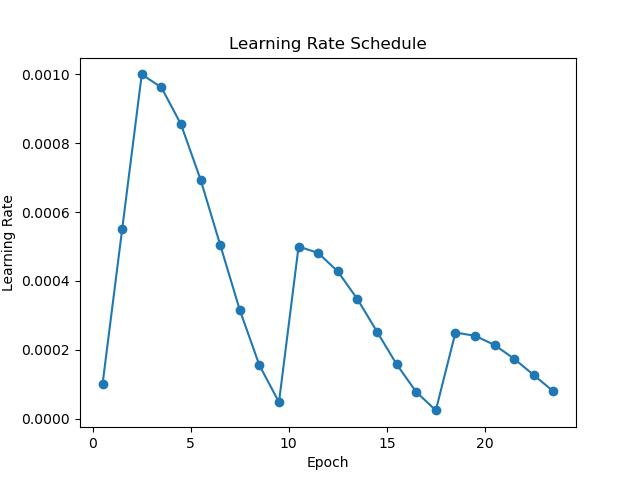

In [16]:
display(Image(filename=paths.train_metric_monitor))

Various performance parameters were monitored during training, on both the training samples and validation. Note that the relatively low scores for training is due to the heavy use of augmentation, and regularisation methods.  The validation samples by contrast were pre-processed in exactly the same way they would be prepared for inference.  Training began with heavy agumentation, and as it progressed the frequency and magnitude of the augmentation effects were reduced.

Plotted metrics:
- Train/Val Loss |  Focal Loss using binary cross entropy
- cmap5 | macro Average Precision score, but with all classes buffered by 5 true positives, to prevent excessive noise from the rare classes.
- LRAP  | Label Ranced Average Precision Score

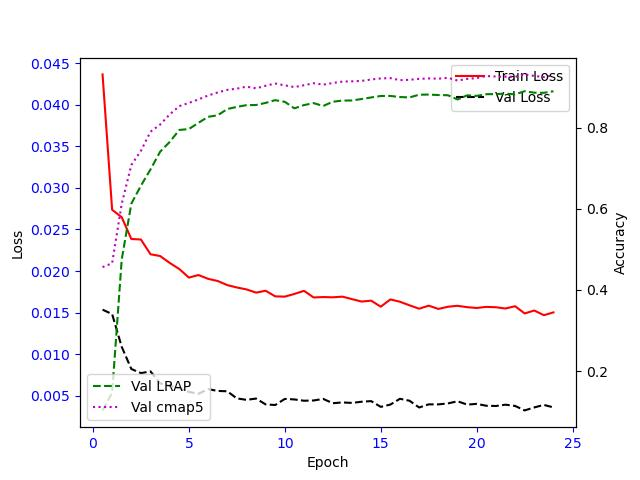

In [17]:
display(Image(filename=paths.learning_rate_monitor))

## Performance on the validation split
- The validation split consists of a random selection of 10% of the audio samples per class, but only for samples where the class had more than 10 samples, otherwise no samples were taken.
- For more than half the classes we don't have much data yet.  What data we have comes mostly from a small number of sites and is thus correlated between samples. For those two reasons there isn't much point trying to make a more sophisticated scheme to accurately predict real-life performance.
- For now I'm just going to make do by looking at the validation set, mainly for classes with more than 50 samples total (so > 5 samples in the validation split).  
- Further development work on training routines will be benchmarked on completely different datasets from Kenya and India, as these area available on Kaggle.  That will reduce the danger of fitting of the training algorithms to this dataset in it's current form.
- At the same time development work ought to be performed on the dataset to improve the size, balance and accuracy of the labels.
- As more data comes to hand from the rarer classes it will become meaningful to develop a rigorous test method.
- From DOC's perspective there is a need to end up with some kind of hidden dataset, with no correllation to the training data.  Either by reserving some of this data by location, or ideally sourcing additional data, targeting the birds of most relevance to conservation goals.

In [18]:
def remove_rare_classes(target_df, pred_df, rare_threshold):
    col_sums = target_df.sum(axis=0)
    original_width = target_df.shape[1]
    mask = col_sums >= rare_threshold

    remove_list=[]
    total_removed = 0
    for column_name, col_sum in col_sums.items():
        if col_sum < rare_threshold:
            remove_list.append((column_name,col_sum))
            total_removed +=col_sum
    
    remove_cols = original_width - mask.sum()
    target_df = target_df.loc[:, mask]
    pred_df = pred_df.loc[:, mask]  

    rows_to_remove = target_df.index[target_df.sum(axis=1) == 0]
    target_df = target_df.drop(rows_to_remove)
    pred_df = pred_df.drop(rows_to_remove)

    rows_with_targets = target_df.any(axis=1)
    target_df = target_df[rows_with_targets]
    pred_df = pred_df[rows_with_targets]

    if remove_cols > 0:
        #print(f'From counting loop: Removing {len(remove_list)} species, {total_removed} instances')  #
        print(f'Removing {remove_cols} classes as they have less than {rare_threshold} samples')
        print(f'Also removing {len(rows_to_remove)} image instances, as they were from those classes')
    return target_df, pred_df


def get_map_score(target_df, pred_df, average='macro'):
    target_df, pred_df = remove_rare_classes(target_df, pred_df, 1)
    col_sums = target_df.sum()
    mask = col_sums >= 1 #keeping this in to avoid division by 0
    targs_arr = target_df.loc[:,mask].copy().values
    preds_arr = pred_df.loc[:,mask].copy().values
    if average is None:
        scores_vals = average_precision_score(targs_arr,preds_arr, average=None)
        if isinstance(scores_vals, float): #handle the situation where only one species is present
            scores_vals = [scores_vals]  
        scores_keys = target_df.columns[mask].tolist()
        scores_dict = {k:v for (k,v) in zip(scores_keys, scores_vals)}
    else:
        scores_dict = {'mean': average_precision_score(targs_arr,preds_arr, average=average)}   
    return scores_dict


def plot_map_by_class(df_target, df_pred, min_samples=5, height=1200):
    df_target, df_pred = remove_rare_classes(df_target, df_pred, min_samples)
    map_dict = get_map_score(df_target, df_pred, average=None)
    col_sums = df_target.sum()
    sorted_cols = col_sums.sort_values(ascending=False)
    names = [name for name in sorted_cols.index]
    counts = [count for count in sorted_cols]
    scores = [map_dict[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], color_continuous_scale='sunsetdark',range_x=[0, 1])
    fig.update_layout(height=height, title='Average Precision Score by Species', plot_bgcolor='rgb(128, 128, 128)')  # Transparent plot background)
    fig.show()
    return names, scores


def get_ba_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return balanced_accuracy_score(target_arr, preds_arr)


def get_accuracy_score(targets_df, preds_df, normalize=True):
    targets_df, preds_df = remove_rare_classes(targets_df, preds_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(preds_df.values, axis=1)
    return skm.accuracy_score(target_arr,  preds_arr, normalize=normalize, sample_weight=None)


def get_f1_score(targets_df, predictions_df):
    targets_df, predictions_df = remove_rare_classes(targets_df, predictions_df, 1)
    target_arr = np.argmax(targets_df.values, axis=1)
    preds_arr = np.argmax(predictions_df.values, axis=1)
    return skm.f1_score(target_arr, preds_arr, pos_label=1, average='macro', zero_division=np.nan)


def get_metrics(targets, predictions, min_freq=5):
    targets, predictions = remove_rare_classes(targets, predictions, min_freq)
    balanced_accuracy = get_ba_score(targets, predictions)
    overall_accuracy = get_accuracy_score(targets, predictions)
    map_scores = get_map_score(targets, predictions)['mean']  #for some reason, this can only run once
    f1_score = get_f1_score(targets, predictions)

    print(Colour.S + f'Overall accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{overall_accuracy:.3f}')
    print(Colour.S + f'Balanced accuracy score for classes with more than {min_freq} samples is: ' + Colour.E + f'{balanced_accuracy:.3f}')
    print(Colour.S + f'macro Average Precision Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{map_scores:.3f}')
    print(Colour.S + f'macro F1 Score for classes with more than {min_freq} samples is: ' + Colour.E + f'{f1_score:.3f}')
    return overall_accuracy, balanced_accuracy, map_scores, f1_score


def build_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=None,
                    cf_pth=None,
                    cf_fig_pth=None,
                    ):
    #targ_df, pred_df = remove_rare_classes(targ_df, pred_df, 1)
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_by_row = np.argmax(target_arr, axis=1)
    predict_by_row = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    target_names = [cols[idx] for idx in target_by_row]
    predict_names = [cols[idx] for idx in predict_by_row]
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_names, predict_names)
    cf_matrix_norm = confusion_matrix(target_names, predict_names, normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f')  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)
    return


def plot_continuous(df, column_name, x_max=None, x_min=None, bins=None):
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(df[column_name], bins=bins, kde=True)
    plt.title(f'Distribution of {column_name} with {bins} Bins and KDE')
    plt.xlabel(column_name)
    ax.set(xlim=(x_min, x_max) if x_min is not None and x_max is not None else None)
    plt.ylabel('Count')
    plt.show()


def plot_two_distributions(dist1, 
                           dist2, 
                           label1='Distribution 1', 
                           label2='Distribution 2', 
                           x_max=None, 
                           y_max=None,
                           bins=None):
    
    plt.figure(figsize=(6, 4))
    ax = sns.histplot(dist1, bins=bins, kde=False, color='blue', label=label1, stat='density')
    sns.histplot(dist2, bins=bins, kde=False, color='orange', label=label2, stat='density', ax=ax)
    plt.title(f'{label1} and {label2} score distributions')
    plt.xlabel('Value')
    ax.set(xlim=(0, x_max) if x_max is not None else None)
    ax.set(ylim=(0, y_max) if y_max is not None else None)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [19]:
df_val_pred = pd.read_pickle(paths.val_preds)
df_val_true = pd.read_pickle(paths.val_targs)
eNames = list(df_val_pred.columns)
common_names  = birdnames.common_names(eNames)
#df_val_pred.columns = pd.Index(common_names)
#df_val_true.columns = pd.Index(common_names)
df_val_pred.head(3)

1139490   1192948   1194042    126247   1346504    134933    135045  \
0  0.049599  0.034328  0.083108  0.019998  0.070045  0.087915  0.932764   
1  0.055177  0.048529  0.072777  0.037243  0.085209  0.080997  0.764645   
2  0.032586  0.022352  0.087374  0.005586  0.009420  0.023812  0.984100   

    1462711   1462737   1564122  ...   yebfly1   yebsee1   yecspi2   yectyr1  \
0  0.035125  0.088647  0.083490  ...  0.076725  0.123695  0.125073  0.054356   
1  0.045893  0.104460  0.104633  ...  0.084673  0.107240  0.101068  0.093299   
2  0.036734  0.053387  0.033366  ...  0.058935  0.052593  0.149062  0.039068   

    yehbla2   yehcar1   yelori1   yeofly1   yercac1    ywcpar  
0  0.057152  0.069062  0.039408  0.092409  0.033172  0.057103  
1  0.100656  0.127137  0.053718  0.128157  0.067990  0.112931  
2  0.028061  0.084960  0.028338  0.069373  0.066162  0.056434  

[3 rows x 206 columns]

In [20]:
df_val_pred.shape

(3654, 206)

In [21]:
df_val_true.head()

1139490  1192948  1194042  126247  1346504  134933  135045  1462711  \
0        0        0        0       0        0       0       1        0   
1        0        0        0       0        0       0       1        0   
2        0        0        0       0        0       0       1        0   
3        0        0        0       0        0       0       0        0   
4        0        0        0       0        0       0       0        0   

   1462737  1564122  ...  yebfly1  yebsee1  yecspi2  yectyr1  yehbla2  \
0        0        0  ...        0        0        0        0        0   
1        0        0  ...        0        0        0        0        0   
2        0        0  ...        0        0        0        0        0   
3        0        0  ...        0        0        0        0        0   
4        0        0  ...        0        0        0        0        0   

   yehcar1  yelori1  yeofly1  yercac1  ywcpar  
0        0        0        0        0       0  
1        0        0        0        0       0  
2        0        0        0        0       0  
3        0        0        0        0       0  
4        0        0        0        0       0  

[5 rows x 206 columns]

In [22]:
df_val_pred.shape

(3654, 206)

In [23]:
df_val_true.head(3)

1139490  1192948  1194042  126247  1346504  134933  135045  1462711  \
0        0        0        0       0        0       0       1        0   
1        0        0        0       0        0       0       1        0   
2        0        0        0       0        0       0       1        0   

   1462737  1564122  ...  yebfly1  yebsee1  yecspi2  yectyr1  yehbla2  \
0        0        0  ...        0        0        0        0        0   
1        0        0  ...        0        0        0        0        0   
2        0        0  ...        0        0        0        0        0   

   yehcar1  yelori1  yeofly1  yercac1  ywcpar  
0        0        0        0        0       0  
1        0        0        0        0       0  
2        0        0        0        0       0  

[3 rows x 206 columns]

In [24]:
df_val_true.shape

(3654, 206)

Let's switch to common names to make this easier to interpret.

In [25]:
if (df_val_pred.shape[0] == df_val_true.shape[0]) and (df_val_pred.shape[0] >=20):
    df_val_pred_common, df_val_true_common = df_val_pred.copy(), df_val_true.copy()
    df_val_pred_common.columns = pd.Index(common_names)
    df_val_true_common.columns = pd.Index(common_names)
    _, _ = plot_map_by_class(df_val_true_common, df_val_pred_common, min_samples=1)
else: print(f'There were only {df_val_pred.shape[0]} rows in the predictions dataframe, too few for mAP scores')

Removing 46 classes as they have less than 1 samples
Also removing 0 image instances, as they were from those classes


- The birds with more samples have much more consistent performance.  
- Anything with less than 5 validation samples (50 samples in total) was not plotted here, as the score would have little meaning.

How about the distribution of the predictions scores?  Let's look at this and decide on suitable thresholds for presence/absence

In [26]:
#df_val_true, df_val_pred = remove_rare_classes(df_val_true, df_val_pred, 5)
#print(f'The reduced dataframe has shape {df_val_true.shape}')

In [27]:
pred_vals = df_val_pred.values
targ_vals = df_val_true.values
tp_scores = (pred_vals * targ_vals).flatten()
tn_scores = (pred_vals * (1-targ_vals)).flatten()
tp_scores= tp_scores[tp_scores != 0]
tn_scores= tn_scores[tn_scores != 0]
print(Colour.S + 'The mean prediction value for true positives is: ' + Colour.E + f'{tp_scores.mean():.2}')
print(Colour.S + 'The mean prediction value for true negatives is: ' + Colour.E + f'{tn_scores.mean():.2}')

The mean prediction value for true positives is: 0.74
The mean prediction value for true negatives is: 0.061


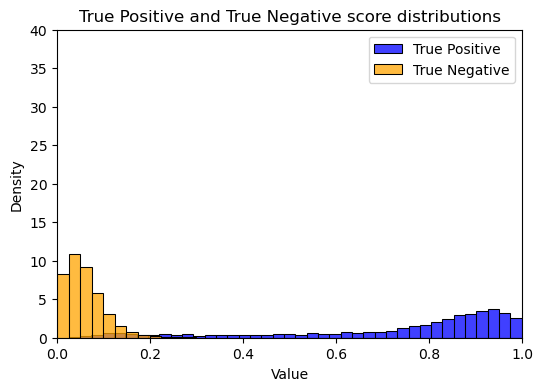

In [28]:
plot_two_distributions(tp_scores, tn_scores, label1='True Positive', label2='True Negative', bins=40, x_max=1, y_max=40)

Taking a closer look at the true positives

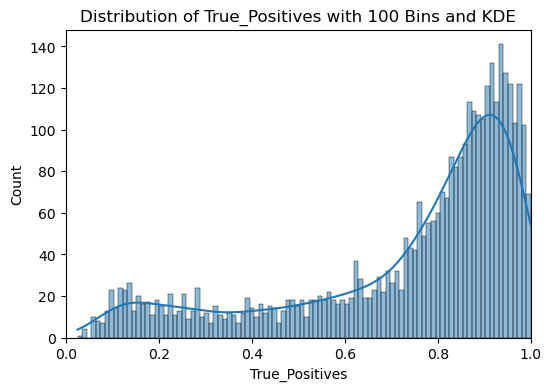

In [29]:
plot_continuous(pd.DataFrame(tp_scores, columns=['True_Positives']), 'True_Positives', x_min=0, x_max=1, bins=100)

In [30]:
df_val_pred.head()

1139490   1192948   1194042    126247   1346504    134933    135045  \
0  0.049599  0.034328  0.083108  0.019998  0.070045  0.087915  0.932764   
1  0.055177  0.048529  0.072777  0.037243  0.085209  0.080997  0.764645   
2  0.032586  0.022352  0.087374  0.005586  0.009420  0.023812  0.984100   
3  0.072077  0.038797  0.024586  0.019685  0.024463  0.029468  0.072110   
4  0.019704  0.011066  0.009960  0.019900  0.026454  0.030320  0.047106   

    1462711   1462737   1564122  ...   yebfly1   yebsee1   yecspi2   yectyr1  \
0  0.035125  0.088647  0.083490  ...  0.076725  0.123695  0.125073  0.054356   
1  0.045893  0.104460  0.104633  ...  0.084673  0.107240  0.101068  0.093299   
2  0.036734  0.053387  0.033366  ...  0.058935  0.052593  0.149062  0.039068   
3  0.059754  0.114085  0.055148  ...  0.045347  0.036157  0.106303  0.042407   
4  0.017078  0.026871  0.058364  ...  0.051474  0.055953  0.097104  0.096766   

    yehbla2   yehcar1   yelori1   yeofly1   yercac1    ywcpar  
0  0.057152  0.069062  0.039408  0.092409  0.033172  0.057103  
1  0.100656  0.127137  0.053718  0.128157  0.067990  0.112931  
2  0.028061  0.084960  0.028338  0.069373  0.066162  0.056434  
3  0.038324  0.045264  0.032627  0.056646  0.072743  0.046368  
4  0.055913  0.063209  0.043175  0.092235  0.059168  0.073140  

[5 rows x 206 columns]

In [31]:
df_val_true.head()

1139490  1192948  1194042  126247  1346504  134933  135045  1462711  \
0        0        0        0       0        0       0       1        0   
1        0        0        0       0        0       0       1        0   
2        0        0        0       0        0       0       1        0   
3        0        0        0       0        0       0       0        0   
4        0        0        0       0        0       0       0        0   

   1462737  1564122  ...  yebfly1  yebsee1  yecspi2  yectyr1  yehbla2  \
0        0        0  ...        0        0        0        0        0   
1        0        0  ...        0        0        0        0        0   
2        0        0  ...        0        0        0        0        0   
3        0        0  ...        0        0        0        0        0   
4        0        0  ...        0        0        0        0        0   

   yehcar1  yelori1  yeofly1  yercac1  ywcpar  
0        0        0        0        0       0  
1        0        0        0        0       0  
2        0        0        0        0       0  
3        0        0        0        0       0  
4        0        0        0        0       0  

[5 rows x 206 columns]

In [32]:
df_targets = df_val_true.copy().reset_index(drop=True)   # your binary-labeled DataFrame
df_long = df_targets.melt(var_name='Targets', value_name='present')
df_result = df_long[df_long['present'] == 1][['Targets']]
df_result.tail()

Targets
752719  ywcpar
752720  ywcpar
752721  ywcpar
752722  ywcpar
752723  ywcpar

In [33]:
df_val_pred.head()

1139490   1192948   1194042    126247   1346504    134933    135045  \
0  0.049599  0.034328  0.083108  0.019998  0.070045  0.087915  0.932764   
1  0.055177  0.048529  0.072777  0.037243  0.085209  0.080997  0.764645   
2  0.032586  0.022352  0.087374  0.005586  0.009420  0.023812  0.984100   
3  0.072077  0.038797  0.024586  0.019685  0.024463  0.029468  0.072110   
4  0.019704  0.011066  0.009960  0.019900  0.026454  0.030320  0.047106   

    1462711   1462737   1564122  ...   yebfly1   yebsee1   yecspi2   yectyr1  \
0  0.035125  0.088647  0.083490  ...  0.076725  0.123695  0.125073  0.054356   
1  0.045893  0.104460  0.104633  ...  0.084673  0.107240  0.101068  0.093299   
2  0.036734  0.053387  0.033366  ...  0.058935  0.052593  0.149062  0.039068   
3  0.059754  0.114085  0.055148  ...  0.045347  0.036157  0.106303  0.042407   
4  0.017078  0.026871  0.058364  ...  0.051474  0.055953  0.097104  0.096766   

    yehbla2   yehcar1   yelori1   yeofly1   yercac1    ywcpar  
0  0.057152  0.069062  0.039408  0.092409  0.033172  0.057103  
1  0.100656  0.127137  0.053718  0.128157  0.067990  0.112931  
2  0.028061  0.084960  0.028338  0.069373  0.066162  0.056434  
3  0.038324  0.045264  0.032627  0.056646  0.072743  0.046368  
4  0.055913  0.063209  0.043175  0.092235  0.059168  0.073140  

[5 rows x 206 columns]

In [34]:
df_val_pred.shape

(3654, 206)

In [35]:
df_result.shape

(3654, 1)

In [36]:
df_combined = pd.concat([df_result.reset_index(drop=True), df_val_pred.reset_index(drop=True)], axis=1)
df_combined.head()

Targets   1139490   1192948   1194042    126247   1346504    134933  \
0  135045  0.049599  0.034328  0.083108  0.019998  0.070045  0.087915   
1  135045  0.055177  0.048529  0.072777  0.037243  0.085209  0.080997   
2  135045  0.032586  0.022352  0.087374  0.005586  0.009420  0.023812   
3   21211  0.072077  0.038797  0.024586  0.019685  0.024463  0.029468   
4   21211  0.019704  0.011066  0.009960  0.019900  0.026454  0.030320   

     135045   1462711   1462737  ...   yebfly1   yebsee1   yecspi2   yectyr1  \
0  0.932764  0.035125  0.088647  ...  0.076725  0.123695  0.125073  0.054356   
1  0.764645  0.045893  0.104460  ...  0.084673  0.107240  0.101068  0.093299   
2  0.984100  0.036734  0.053387  ...  0.058935  0.052593  0.149062  0.039068   
3  0.072110  0.059754  0.114085  ...  0.045347  0.036157  0.106303  0.042407   
4  0.047106  0.017078  0.026871  ...  0.051474  0.055953  0.097104  0.096766   

    yehbla2   yehcar1   yelori1   yeofly1   yercac1    ywcpar  
0  0.057152  0.069062  0.039408  0.092409  0.033172  0.057103  
1  0.100656  0.127137  0.053718  0.128157  0.067990  0.112931  
2  0.028061  0.084960  0.028338  0.069373  0.066162  0.056434  
3  0.038324  0.045264  0.032627  0.056646  0.072743  0.046368  
4  0.055913  0.063209  0.043175  0.092235  0.059168  0.073140  

[5 rows x 207 columns]

In [37]:
def predictions_by_class(class_name, df, show_results=False):
    df = df[[class_name, 'Targets']]
    positive_vals = df[df['Targets']==class_name][class_name].values
    negative_vals = df[df['Targets']!=class_name][class_name].values
    positive_mean, negative_mean = 0,0
    if len(positive_vals) >= 1:
        positive_mean = positive_vals.mean()
        negative_mean = negative_vals.mean()
    
    if show_results:
        print(f'The mean for true positives is {positive_mean}')
        print(f'The mean for true negatives is {negative_mean}')
        plot_two_distributions(positive_vals, 
                        negative_vals, 
                        label1=f'True Positive {class_name}', 
                        label2=f'True Negative {class_name}', 
                        bins=40, 
                        x_max=1, 
                        y_max=40)
    return positive_mean, negative_mean

#positive_mean, negative_mean = predictions_by_class('21211', df_combined, show_results=True)

In [38]:
#This class does not appear in the validation dataset, so there are no true positives
#positive_mean, negative_mean = predictions_by_class('1139490', df_combined, show_results=True)

A perfect classifier would have no overlap between these distributions.  In our case, the overlap is small. We would have virtually no false negatives with a threshold of 0.2, and a few false positives.   But in practice on soundscapes we already found that this underestimates the spread of the negatives. For now let's set a threshold of 0.3 and see what performance we get from some practical use metrics.

In [39]:
threshold = 0.3
pred_vals_binary = (pred_vals > threshold).astype(int)

In [40]:
targets = sorted(list(df_val_pred.columns))
scores_dict = classification_report(targ_vals, pred_vals_binary, target_names=targets, digits=2, output_dict=True, zero_division=1)
df_scores = pd.DataFrame.from_dict(scores_dict, orient='index')
df_scores_summary = df_scores.tail(4)
df_scores = df_scores.head(-4)
df_scores = df_scores.sort_values(by='support', ascending=False)
df_scores_summary

precision    recall  f1-score  support
micro avg      0.604496  0.890531  0.720150   3654.0
macro avg      0.565147  0.890555  0.638366   3654.0
weighted avg   0.639647  0.890531  0.737314   3654.0
samples avg    0.731824  0.890531  0.765363   3654.0

In [41]:
len(targets)

206

In [42]:
pd.set_option('display.max_rows', 60)
df_scores.head()

precision    recall  f1-score  support
grekis   0.622222  0.933333  0.746667    120.0
compau   0.760870  0.990566  0.860656    106.0
trokin   0.589404  0.936842  0.723577     95.0
roahaw   0.731481  0.849462  0.786070     93.0
whtdov   0.585938  0.937500  0.721154     80.0

In [43]:
ordered_targets = sorted(list(df_scores.index))
df_val_pred_binary = pd.DataFrame(data=pred_vals_binary, columns=targets)  #columns=ordered_targets
df_val_pred_binary = df_val_pred_binary[ordered_targets]
df_val_true = df_val_true[ordered_targets]
df_val_true.head(3)

ordered_common_val_names = [birdnames.common_name(eName) for eName in ordered_targets]
df_val_pred_binary.columns = pd.Index(ordered_common_val_names)
df_val_true.columns = pd.Index(ordered_common_val_names)

Since we are treating this as a multi-label problem it isn't possible to make a single confusion matrix summarising all samples, since some samples have mutliple values for true.  We could produce individual $2 \times 2$ confusion matrices for each class, but this isn't especially interesting for current purposes.  Instead let's remove all the multi-label rows, and treat the remainder as multi-class, single-label.

In [44]:
def build_ml_cf_matrix(targ_df, 
                    pred_df, 
                    cf_norm_pth=None,
                    cf_pth=None,
                    cf_fig_pth=None,
                    ):
    '''Make a pseudo-confusioni matrix for a multi-label classifier by filtering out any multi-label rows'''
    
    row_sums = targ_df.sum(axis=1)
    pred_df = pred_df.reindex(targ_df.index)
    targ_df = targ_df[row_sums == 1]
    pred_df = pred_df[row_sums == 1]
    
    print(f'Building a confusion from {len(targ_df)} samples with single labels')
    print(f'The number of unique classes in the input dataframes {len(set(list(targ_df.columns)))}')
    
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_idxs = np.argmax(target_arr, axis=1)
    predict_idxs = np.argmax(predicts_arr, axis=1)
    cols = targ_df.columns
    classes = cols.tolist()
    cf_matrix_raw = confusion_matrix(target_idxs, predict_idxs, labels=list(range(target_arr.shape[1])))
    cf_matrix_norm = confusion_matrix(target_idxs, predict_idxs, labels=list(range(target_arr.shape[1])), normalize='true')
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
                              columns=[i for i in classes]).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=[i for i in classes],
                             columns=[i for i in classes])
    df_cm_raw['Total Annotated'] = df_cm_raw[classes].sum(axis=1)
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f',  cmap="crest")  # cmap="crest" for green/blue
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    ax_cm.set_xticks(range(len(classes)))
    ax_cm.set_xticklabels(classes, rotation=90)
    df_cm_norm['Total Annotated'] = df_cm_norm[classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm['Total Annotated'].round(decimals=0)
    
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)
    return

In [45]:
def build_ml_cf_matrix(targ_df, 
                       pred_df, 
                       cf_norm_pth=None,
                       cf_pth=None,
                       cf_fig_pth=None):
    '''Make a pseudo-confusion matrix for a multi-label classifier by filtering out any multi-label rows and sorting by class size'''
    
    row_sums = targ_df.sum(axis=1)
    pred_df = pred_df.reindex(targ_df.index)
    targ_df = targ_df[row_sums == 1]
    pred_df = pred_df[row_sums == 1]
    
    print(f'Building a confusion from {len(targ_df)} samples with single labels')
    
    # Drop columns (classes) that have no samples in targ_df
    class_sizes = targ_df.sum(axis=0)
    nonzero_classes = class_sizes[class_sizes > 0].sort_values(ascending=False)
    sorted_classes = nonzero_classes.index.tolist()

    # Reorder both DataFrames to match the sorted class list
    targ_df = targ_df[sorted_classes]
    pred_df = pred_df[sorted_classes]

    print(f'The number of unique classes with data: {len(sorted_classes)}')

    # Convert to numpy arrays
    target_arr = targ_df.to_numpy()
    predicts_arr = pred_df.to_numpy()
    target_idxs = np.argmax(target_arr, axis=1)
    predict_idxs = np.argmax(predicts_arr, axis=1)

    # Build confusion matrices
    cf_matrix_raw = confusion_matrix(target_idxs, predict_idxs, labels=list(range(len(sorted_classes))))
    cf_matrix_norm = confusion_matrix(target_idxs, predict_idxs, labels=list(range(len(sorted_classes))), normalize='true')

    # Create DataFrames for display
    df_cm_norm = pd.DataFrame(cf_matrix_norm, index=sorted_classes, columns=sorted_classes).round(decimals=3)
    df_cm_raw = pd.DataFrame(cf_matrix_raw, index=sorted_classes, columns=sorted_classes)

    df_cm_raw['Total Annotated'] = df_cm_raw[sorted_classes].sum(axis=1)
    df_cm_norm['Total Annotated'] = df_cm_norm[sorted_classes].sum(axis=1).round(decimals=0)

    # Plot
    plt.figure(figsize=(12, 11))
    ax_cm = sns.heatmap(df_cm_norm, annot=False, fmt='.1f', cmap="crest")
    ax_cm.set(xlabel="Prediction", ylabel="Target")
    ax_cm.set_xticks(range(len(sorted_classes)))
    ax_cm.set_xticklabels(sorted_classes, rotation=90)

    # Save outputs
    if cf_fig_pth is not None:
        plt.savefig(cf_fig_pth)
    if cf_pth is not None:
        df_cm_raw.to_csv(cf_pth)
    if cf_norm_pth is not None:
        df_cm_norm.to_csv(cf_norm_pth)

    return

Building a confusion from 3654 samples with single labels
The number of unique classes with data: 160


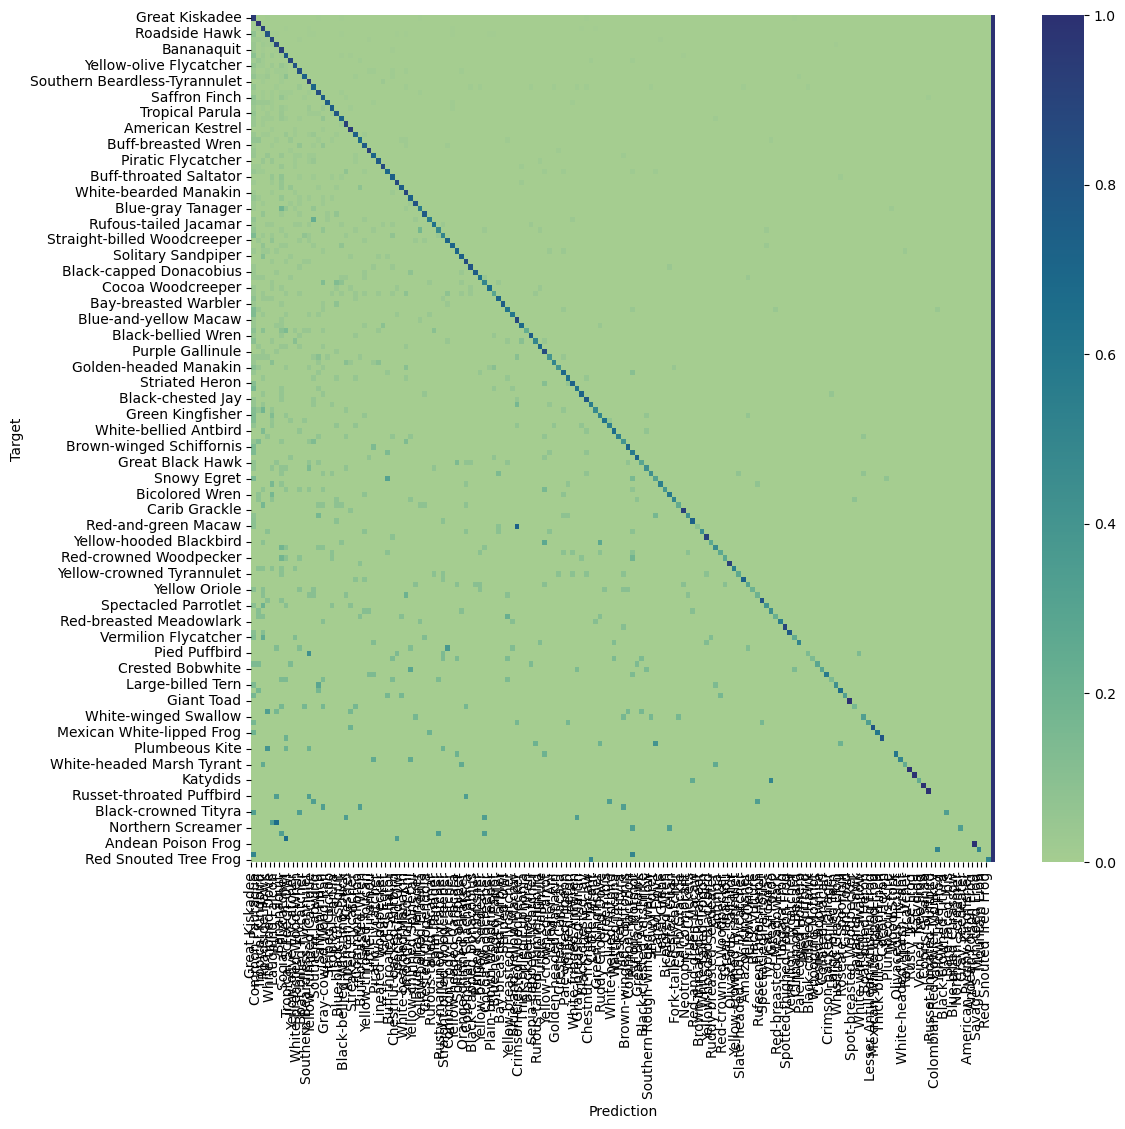

In [46]:
build_ml_cf_matrix(df_val_true, df_val_pred_binary, cf_fig_pth='/home/olly/Desktop/figure.jpg', cf_norm_pth='/home/olly/Desktop/confusion.csv')

## Prediction on soundscapes in 5 second intervals

In [47]:
print('\nThe first three recordings to be precessed are:')
for i in range(min(3, len(paths.soundscapes))):
    print(paths.soundscapes[i])


The first three recordings to be precessed are:
/home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_112000.ogg
/home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000.ogg


In [48]:
model = models.get_model(0)
prediction_dfs = []
for idx in range(len(models.args_list)):
    df = inference(paths.soundscapes, models, idx, cores=cfg.CORES)
    prediction_dfs.append(df)

RuntimeError: Error(s) in loading state_dict for BirdSoundModel:
	size mismatch for att_block.classify.linear.weight: copying a param with shape torch.Size([1024, 2048]) from checkpoint, the shape in current model is torch.Size([640, 1280]).
	size mismatch for att_block.classify.linear.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([640]).
	size mismatch for att_block.classify.output.weight: copying a param with shape torch.Size([206, 1024]) from checkpoint, the shape in current model is torch.Size([206, 640]).

Average the various prediction dataframes

In [ ]:
prediction_dfs[0].head()

row_id  \
0  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...   
2  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...   
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...   

                                           File_Path   1139490   1192948  \
0  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...  0.093093  0.115050   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...  0.197608  0.169966   
2  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...  0.043445  0.045436   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...  0.061428  0.080389   
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_D...  0.064535  0.098600   

    1194042    126247   1346504    134933    135045   1462711  ...   yebfly1  \
0  0.212449  0.035662  0.110929  0.198553  0.072390  0.069416  ...  0.147653   
1  0.310499  0.049084  0.475336  0.090146  0.101723  0.188438  ...  0.141551   
2  0.058090  0.063837  0.051888  0.079288  0.064858  0.041718  ...  0.131744   
3  0.079141  0.047182  0.082844  0.192046  0.062761  0.065622  ...  0.134803   
4  0.075403  0.061132  0.055802  0.182444  0.064701  0.063703  ...  0.136062   

    yebsee1   yecspi2   yectyr1   yehbla2   yehcar1   yelori1   yeofly1  \
0  0.259270  0.135712  0.228569  0.206938  0.143270  0.194309  0.305148   
1  0.098292  0.144402  0.188168  0.153159  0.137250  0.125199  0.326912   
2  0.196119  0.143220  0.202421  0.223281  0.135755  0.195843  0.262254   
3  0.139041  0.123888  0.238530  0.168328  0.148293  0.249826  0.293759   
4  0.166154  0.140721  0.219154  0.200427  0.153377  0.313360  0.280636   

    yercac1    ywcpar  
0  0.159648  0.293626  
1  0.132291  0.276386  
2  0.127236  0.277879  
3  0.147150  0.302109  
4  0.193590  0.290074  

[5 rows x 208 columns]

In [ ]:
prediction_columns = prediction_dfs[0].columns[2:]
prediction_columns

Index(['1139490', '1192948', '1194042', '126247', '1346504', '134933',
       '135045', '1462711', '1462737', '1564122',
       ...
       'yebfly1', 'yebsee1', 'yecspi2', 'yectyr1', 'yehbla2', 'yehcar1',
       'yelori1', 'yeofly1', 'yercac1', 'ywcpar'],
      dtype='object', length=206)

In [ ]:
prediction_columns = prediction_dfs[0].columns[2:]
values_list = [df[prediction_columns].values for df in prediction_dfs]
average_vals = np.zeros_like(values_list[0])

for array in values_list:
    average_vals = average_vals + array 

average_vals = average_vals / len(values_list)
predictions = pd.DataFrame(data=average_vals, columns=prediction_columns)
predictions.insert(0, 'row_id', prediction_dfs[0]['row_id']) 

In [ ]:
predictions.to_csv(paths.predictions_csv, index=False)

In [ ]:
predictions.shape

(24, 207)

In [ ]:
pd.set_option('display.max_colwidth', 200)
predictions[predictions['row_id'].str.contains('H02_20230420_074000')].head(10)

row_id  \
12   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_5   
13  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_10   
14  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_15   
15  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_20   
16  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_25   
17  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_30   
18  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_35   
19  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_40   
20  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_45   
21  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/test_soundscapes/H02_20230420_074000_50   

     1139490   1192948   1194042    126247   1346504    134933    135045  \
12  0.059868  0.071880  0.077712  0.091558  0.103132  0.106566  0.169285   
13  0.075330  0.081915  0.090872  0.118266  0.116643  0.122895  0.151323   
14  0.060787  0.080281  0.078071  0.124528  0.094359  0.101440  0.149199   
15  0.109584  0.133194  0.100674  0.061394  0.136331  0.100064  0.188138   
16  0.081815  0.098380  0.076030  0.061716  0.133392  0.099818  0.148663   
17  0.079409  0.095437  0.081594  0.069155  0.108343  0.112700  0.158182   
18  0.083910  0.102549  0.082036  0.103444  0.117525  0.092815  0.163596   
19  0.078753  0.100756  0.090621  0.065598  0.138636  0.121652  0.172136   
20  0.063627  0.077650  0.090556  0.096742  0.089194  0.112755  0.166251   
21  0.078618  0.091163  0.089008  0.081650  0.099154  0.116466  0.171674   

     1462711   1462737  ...   yebfly1   yebsee1   yecspi2   yectyr1   yehbla2  \
12  0.066469  0.117383  ...  0.147027  0.093749  0.181287  0.225415  0.157471   
13  0.079136  0.133531  ...  0.172478  0.151145  0.262954  0.240641  0.217032   
14  0.065753  0.130911  ...  0.157151  0.116960  0.194925  0.217900  0.189034   
15  0.124104  0.214915  ...  0.179367  0.094034  0.152691  0.228339  0.182457   
16  0.093056  0.157713  ...  0.185610  0.102343  0.165282  0.242793  0.206132   
17  0.085511  0.152311  ...  0.179611  0.111921  0.177273  0.229089  0.203308   
18  0.101392  0.157781  ...  0.185127  0.102876  0.172226  0.241863  0.196708   
19  0.095416  0.170322  ...  0.173730  0.105909  0.155082  0.244066  0.176405   
20  0.065421  0.118407  ...  0.167930  0.119909  0.244253  0.233438  0.200224   
21  0.081365  0.144317  ...  0.184583  0.130685  0.207890  0.238884  0.207091   

     yehcar1   yelori1   yeofly1   yercac1    ywcpar  
12  0.189263  0.162480  0.263572  0.142765  0.283873  
13  0.211820  0.204080  0.322707  0.176241  0.325030  
14  0.191673  0.198625  0.299208  0.179592  0.291327  
15  0.231555  0.163648  0.296526  0.161095  0.302578  
16  0.220347  0.185505  0.321716  0.176267  0.323075  
17  0.210893  0.186916  0.295354  0.168251  0.307171  
18  0.240767  0.190263  0.314249  0.202603  0.323028  
19  0.218598  0.170274  0.298238  0.145406  0.311158  
20  0.189320  0.197007  0.316327  0.192296  0.287525  
21  0.224650  0.200414  0.305786  0.185821  0.297749  

[10 rows x 207 columns]

## Re-check the val split with the inference model

In [ ]:
df_val = pd.read_csv(paths.val_csv)
df_val.head()

filename primary_label  \
0                  Cropped_Train_Audio/135045/iNat1208572_4.ogg        135045   
1                  Cropped_Train_Audio/135045/iNat1208552_2.ogg        135045   
2                  Cropped_Train_Audio/135045/iNat1208551_1.ogg        135045   
3  Original_Data/birdclef-2025/train_audio/21211/iNat361221.ogg         21211   
4  Original_Data/birdclef-2025/train_audio/21211/iNat359445.ogg         21211   

  secondary_labels     class            centres           original_file  \
0               []  amphibia  [6.0, 15.6, 25.1]  135045/iNat1208572.ogg   
1               []  amphibia        [6.0, 24.7]  135045/iNat1208552.ogg   
2               []  amphibia  [6.0, 18.0, 30.0]  135045/iNat1208551.ogg   
3               []  amphibia  [4.5, 11.2, 14.0]    21211/iNat361221.ogg   
4               []  amphibia        [5.7, 11.0]    21211/iNat359445.ogg   

   duration  \
0       NaN   
1       NaN   
2       NaN   
3       NaN   
4       NaN   

                                                                                           filepath  
0                  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg  
1                  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg  
2                  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg  
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/21211/iNat361221.ogg  
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/21211/iNat359445.ogg

In [ ]:
val_paths = [Path(path_string) for path_string in df_val['filepath']]
val_paths[:3]

[PosixPath('/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg'),
 PosixPath('/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg'),
 PosixPath('/home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg')]

Overall File List:   0%|          | 0/3 [00:00<?, ?it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg to 40 seconds


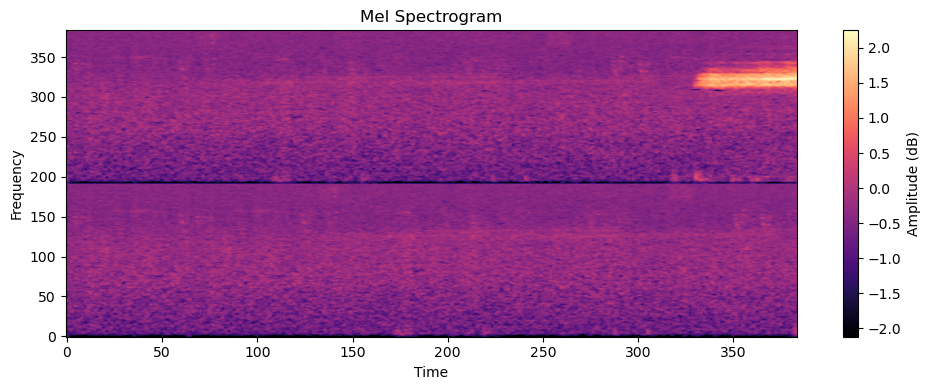

Overall File List:  33%|███▎      | 1/3 [00:00<00:01,  1.82it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg to 40 seconds


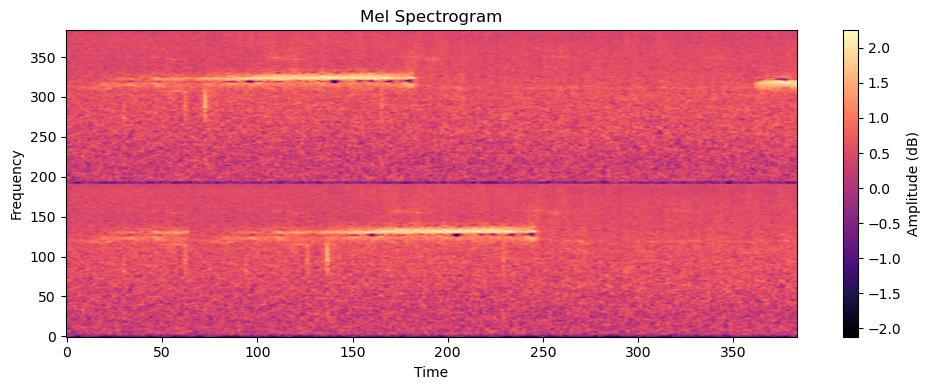

Overall File List:  67%|██████▋   | 2/3 [00:01<00:00,  1.98it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg to 40 seconds


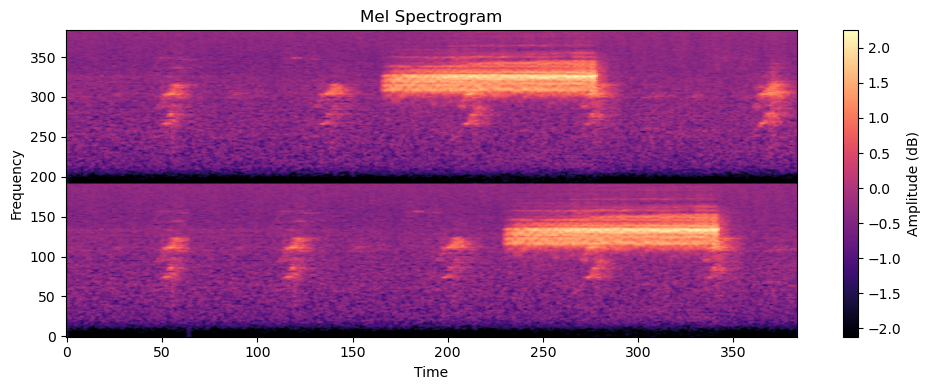

Overall File List: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


In [ ]:
val_135045_df = inference(val_paths[:3], models, 0, cores=cfg.CORES)

We can just look at samples from 135045 and see how they went.  The training model produces scores around 0.5 to 0.6

In [ ]:
val_135045_df[['row_id', 'File_Path', '135045']]

row_id  \
0    /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_5   
1   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_10   
2   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_15   
3   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_20   
4   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_25   
5   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_30   
6   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_35   
7   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4_40   
8    /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_5   
9   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_10   
10  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_15   
11  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_20   
12  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_25   
13  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_30   
14  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_35   
15  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2_40   
16   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_5   
17  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_10   
18  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_15   
19  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_20   
20  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_25   
21  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_30   
22  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_35   
23  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1_40   

                                                                           File_Path  \
0   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
1   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
2   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
3   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
4   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
5   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
6   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
7   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208572_4.ogg   
8   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
9   /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
10  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
11  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
12  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
13  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
14  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
15  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208552_2.ogg   
16  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg   
17  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg   
18  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg   
19  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train_Audio/135045/iNat1208551_1.ogg   
20  /home/olly/Desktop/Kaggle_BC25/Data/Cropped_Train

Overall File List:   0%|          | 0/4 [00:00<?, ?it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC113758.ogg to 10 seconds


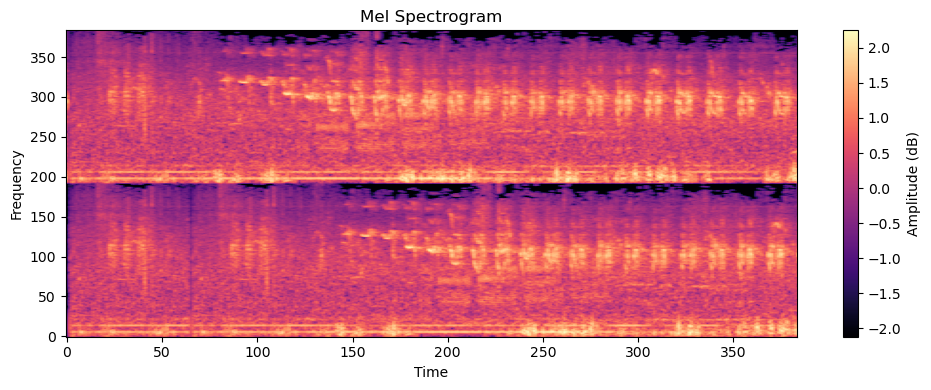

Overall File List:  25%|██▌       | 1/4 [00:00<00:01,  2.96it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC119209.ogg to 10 seconds


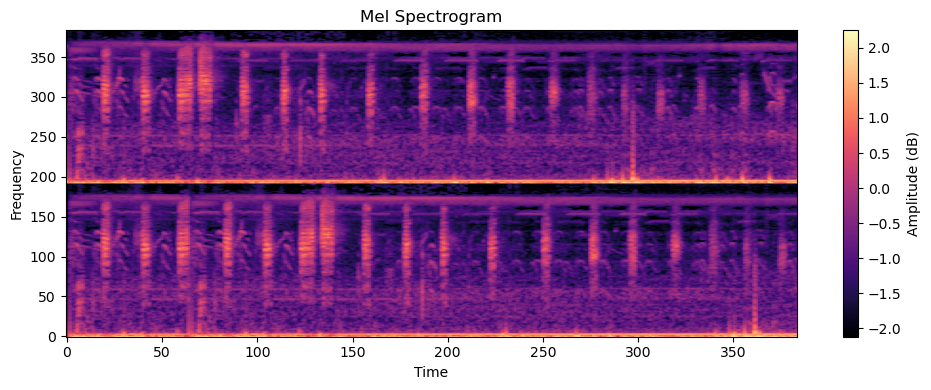

Overall File List:  50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC120034.ogg to 10 seconds


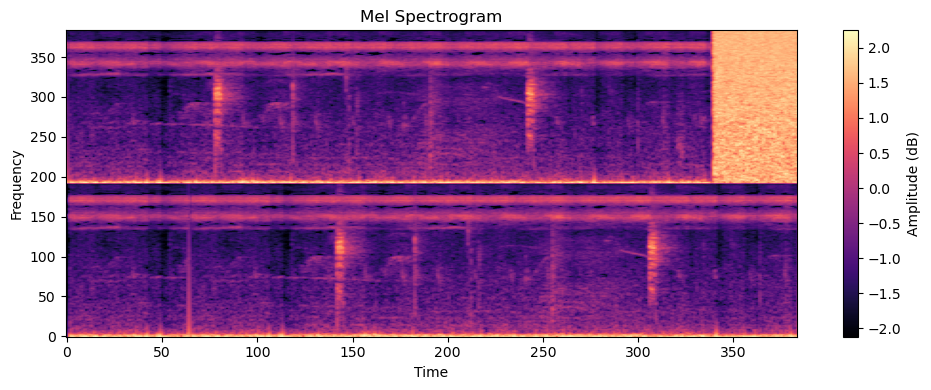

Overall File List:  75%|███████▌  | 3/4 [00:00<00:00,  3.45it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC127702.ogg to 10 seconds


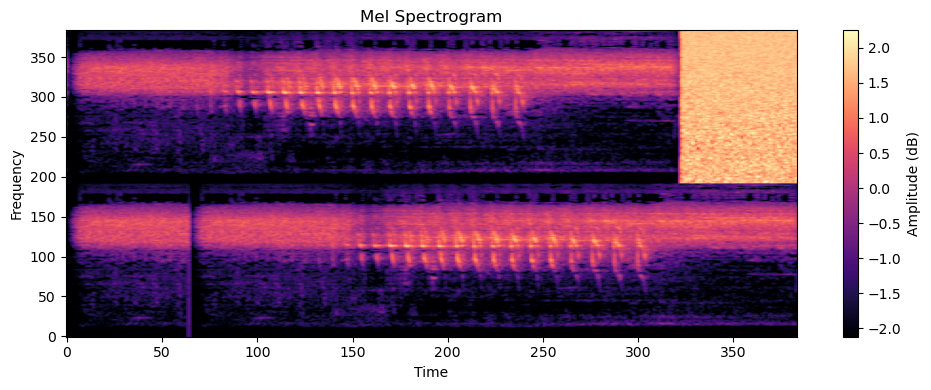

Overall File List: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


In [ ]:
audios_to_check = ['amakin1/XC113758.ogg', 'amakin1/XC119209.ogg','amakin1/XC120034.ogg','amakin1/XC127702.ogg']
audios_to_check = [paths.train_audios  / path_string for path_string in audios_to_check]
check_amakin1_df = inference(audios_to_check, models, 0, cores=cfg.CORES)

In [ ]:
check_amakin1_df[['row_id','File_Path', 'amakin1']].head(20)

row_id  \
0   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC113758_5   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC113758_10   
2   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC119209_5   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC119209_10   
4   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC120034_5   
5  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC120034_10   
6   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC127702_5   
7  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC127702_10   

                                                                                          File_Path  \
0  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC113758.ogg   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC113758.ogg   
2  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC119209.ogg   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC119209.ogg   
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC120034.ogg   
5  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC120034.ogg   
6  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC127702.ogg   
7  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/amakin1/XC127702.ogg   

    amakin1  
0  0.758767  
1  0.365170  
2  0.633880  
3  0.376650  
4  0.562284  
5  0.239595  
6  0.472534  
7  0.197037

In [ ]:
df_compau = df_val[df_val['primary_label'] == 'compau']
df_compau.head()

filename  \
928  Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
929  Original_Data/birdclef-2025/train_audio/compau/XC455591.ogg   
930  Original_Data/birdclef-2025/train_audio/compau/XC254120.ogg   
931  Original_Data/birdclef-2025/train_audio/compau/XC900268.ogg   
932  Original_Data/birdclef-2025/train_audio/compau/XC307201.ogg   

    primary_label secondary_labels class centres        original_file  \
928        compau               []  aves      []  compau/XC521299.ogg   
929        compau               []  aves      []  compau/XC455591.ogg   
930        compau               []  aves      []  compau/XC254120.ogg   
931        compau               []  aves      []  compau/XC900268.ogg   
932        compau               []  aves      []  compau/XC307201.ogg   

     duration  \
928       NaN   
929       NaN   
930       NaN   
931       NaN   
932       NaN   

                                                                                            filepath  
928  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg  
929  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC455591.ogg  
930  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC254120.ogg  
931  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC900268.ogg  
932  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC307201.ogg

Overall File List:   0%|          | 0/3 [00:00<?, ?it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg to 50 seconds


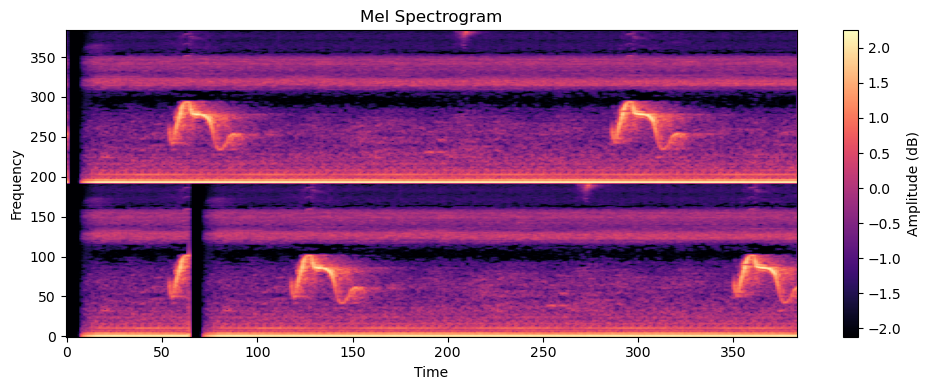

Overall File List:  33%|███▎      | 1/3 [00:00<00:01,  1.94it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC455591.ogg to 50 seconds


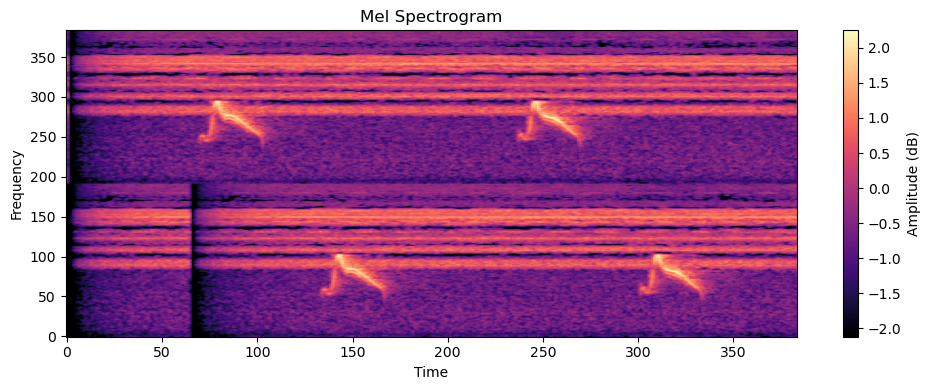

Overall File List:  67%|██████▋   | 2/3 [00:01<00:00,  1.96it/s]

Padded sample /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC254120.ogg to 50 seconds


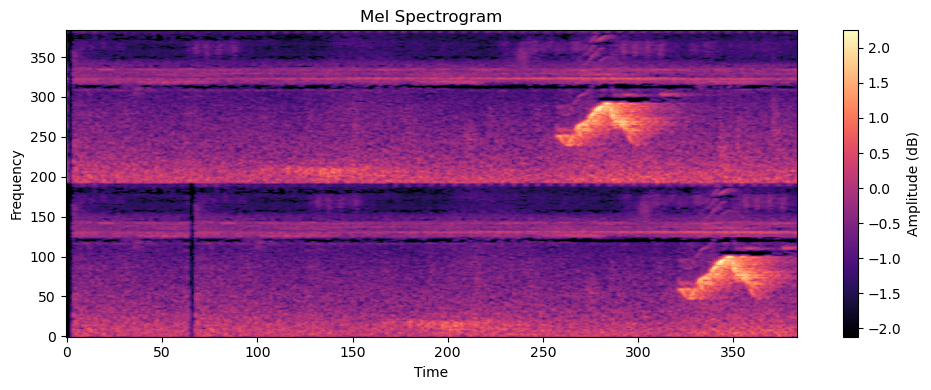

Overall File List: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


In [ ]:
val_paths = [Path(path_string) for path_string in df_compau['filepath']][:3]
df_val_compau = inference(val_paths[:3], models, 0, cores=cfg.CORES)

In [ ]:
df_val_compau[['row_id','File_Path', 'compau']].head(10)

row_id  \
0   /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_5   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_10   
2  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_15   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_20   
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_25   
5  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_30   
6  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_35   
7  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_40   
8  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_45   
9  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299_50   

                                                                                         File_Path  \
0  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
1  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
2  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
3  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
4  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
5  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
6  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
7  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
8  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   
9  /home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/compau/XC521299.ogg   

     compau  
0  0.676765  
1  0.663899  
2  0.675650  
3  0.757117  
4  0.686849  
5  0.742958  
6  0.640816  
7  0.749395  
8  0.689915  
9  0.366367

In [ ]:
#new_check_dir = '/home/olly/Desktop/Kaggle_BC25/Data/Original_Data/birdclef-2025/train_audio/21211'
#audios_to_check = list(Path(new_check_dir).glob("*.ogg"))
#check_val_df = inference(audios_to_check, models, 0, cores=cfg.CORES)

In [ ]:
#for pred in check_val_df['21211'].to_list():
#    print(pred)